<a href="https://colab.research.google.com/github/akariiijima/AdversarialExample/blob/master/kerasCNN_AE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [0]:
df=pd.read_csv("mnist_train.csv")
#1-10 labels
labels=df["5"].values
#one-hot labels
labels = tf.keras.utils.to_categorical(labels)

df.drop("5", axis=1, inplace=True)
pixels=df.values
pixels=pixels/255
pixels=pixels.reshape(len(df),28,28,1)

In [0]:
class AdversarialLayer(keras.layers.Layer):
    def __init__(self, units):
      super().__init__()
      self.units = units
    def build(self, input_shape):
      #重みの定義
      self.kernel = self.add_weight(
      "kernel", shape=[int(input_shape[-1]), self.units],
      initializer='glorot_uniform', trainable=True
      )
      #バイアスの定義
      self.bias = self.add_weight(
      "bias", shape=[self.units,],
      initializer='zeros', trainable=False
      )
    def call(self, input):
      output = tf.matmul(input, self.kernel)
      output = tf.add(output, self.bias)
      return tf.nn.relu(output)
      


In [133]:
input = tf.constant([[1., 0., 0.], [0., 1., 0.]])
layer = AdversarialLayer(5)
print(input)
print(layer(input))

Tensor("Const_1:0", shape=(2, 3), dtype=float32)
Tensor("adversarial_layer_2/Relu:0", shape=(2, 5), dtype=float32)


In [0]:
modelCNN=keras.Sequential([
    #keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Conv2D(20, (3, 3), padding="valid", activation=tf.nn.relu, input_shape=(28, 28,1)),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Conv2D(50, (3, 3), padding="valid", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(225, activation=tf.nn.relu),
    keras.layers.Dense(10, activation="softmax"),
])

In [128]:
modelCNN.compile(optimizer=tf.train.AdamOptimizer(), loss="categorical_crossentropy", metrics=["accuracy"])
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 26, 26, 20)        200       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 6, 6, 50)          9050      
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 2, 2, 50)          0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 2, 2, 50)          200       
_________________________________________________________________
flatten_87 (Flatten)         (None, 200)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 225)               45225     
__________

In [107]:
evaluate = modelCNN.evaluate(x=pixels, y=labels, batch_size=None, verbose=1, sample_weight=None, steps=None)
print(modelCNN.metrics_names)
evaluate

59999/59999 [==============================] - 3s 57us/step
['loss', 'acc']


[0.12901365068593076, 0.9609660161002683]

In [112]:
fit=modelCNN.fit(pixels, labels,epochs=10, batch_size=4096,validation_split=0.2)
fit.history['loss']

Train on 47999 samples, validate on 12000 samples
Epoch 1/10
47999/47999 [==============================] - 3s 59us/step - loss: 0.0223 - acc: 0.9947 - val_loss: 0.0512 - val_acc: 0.9834
Epoch 2/10
47999/47999 [==============================] - 3s 60us/step - loss: 0.0208 - acc: 0.9950 - val_loss: 0.0539 - val_acc: 0.9823
Epoch 3/10
47999/47999 [==============================] - 3s 59us/step - loss: 0.0193 - acc: 0.9955 - val_loss: 0.0476 - val_acc: 0.9842
Epoch 4/10
47999/47999 [==============================] - 3s 58us/step - loss: 0.0180 - acc: 0.9959 - val_loss: 0.0543 - val_acc: 0.9817
Epoch 5/10
47999/47999 [==============================] - 3s 59us/step - loss: 0.0168 - acc: 0.9961 - val_loss: 0.0473 - val_acc: 0.9849
Epoch 6/10
47999/47999 [==============================] - 3s 59us/step - loss: 0.0156 - acc: 0.9967 - val_loss: 0.0469 - val_acc: 0.9843
Epoch 7/10
47999/47999 [==============================] - 3s 59us/step - loss: 0.0148 - acc: 0.9971 - val_loss: 0.0415 - val_acc

[0.022280924101905075,
 0.020828009405227863,
 0.01925884524898964,
 0.017978081693566825,
 0.01677995002130323,
 0.01560666213681047,
 0.014751679090585362,
 0.013832652842934366,
 0.012875582369768115,
 0.012221509982917557]

(60000, 28, 28)
(60000, 784)

What we want our adversarial example to look like: 


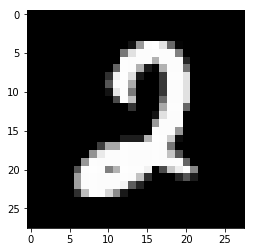



Adversarial Example: 


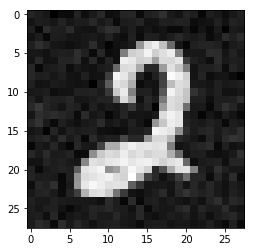

Network Prediction: 8

Network Output: 
[[0.19 0.11 0.06 0.1  0.07 0.03 0.03 0.12 0.25 0.03]]



In [195]:
def input_derivative(model, x, goal):
    """ Calculate derivatives wrt the intputs """
    y_true = keras.layers.Input(shape=(10,))
    ce = keras.losses.categorical_crossentropy(y_true, model.output)
    grad_ce = tf.keras.backend.gradients(ce, model.inputs)
    # Create a function to be able to run this computation graph
    func = keras.backend.function(model.inputs + [y_true], grad_ce)
    output = func([x, goal])
    return output

def adversarial(model, n, steps, eta):
    """
    model: MNIST model
    n:     integer. goal label (just an int, the function transfroms it into a one-hot vector)
    steps: integer. number of steps for gradient descent
    eata:  integer. step size for gradient descent
    """
    # Set the goal output
    goal = tf.keras.utils.to_categorical(n, 10)
    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (1,784))
    # Gradient descent on the input
    for i in range(steps):
      # Calculate the derivative
      d = input_derivative(model, x, goal)
      # The Gradient update on x
      x -= eta*d[0]
      print("step:{} done...".format(i+1))
    return x

def generate(n):
    """
    n: integer
    goal label ( not hot vector)
    """
    a = adversarial(model, n, 100, 1)
    x = np.round(model.predict(a), 2)

    plt.imshow(a.reshape(28,28), cmap='gray')


def sneaky_adversarial(model, n, x_target, steps, eta, lam=0.5):
    """
    model:    model object
    n:        integer
         our toal label
    x_target: numpy vector
         our goal image for the adversarial example
    steps:    integer
         number of steps for gradient descent
    lam:      float
         lambda, our regularization parameter. Default is 0.5
    """

    # Set the goal output
    goal = tf.keras.utils.to_categorical(n, 10)
    
    # Create a random noise
    x = np.random.normal(0.5, 0.3, (1,784))

    
    # Gradient descent on the input
    for i in range(steps):
      # Calculate the derivative
      d = input_derivative(model, x, goal)
      # The grads update on x, with an added penalty to the cost function
      x -= eta * (d[0] + lam * (x - x_target))

    return x


def sneaky_generate(n, m):
    """
    n:    int 0-9, the target number to match
    m:    index of example image to use (from the test set)
    """
    # Find random instance of m in test set
    idx = np.random.randint(0,10000)
    while np.where(y_test[idx] == 1)[0][0] != m: 
      idx += 1
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial(model, n, x_test[idx], 10, 1)
    x = np.round(model.predict(a), 2)
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(x_test[idx].reshape((28,28)), cmap='gray')
    plt.show()
    print('\n')
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='gray')
    plt.show()
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    print('Network Output: \n' + str(x) + '\n')
    return a

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(x_train.shape)
x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)
x_train = x_train/255.
x_test = x_test/255.
print(x_train.shape)


a = keras.layers.Input(shape=(28*28,))
x = keras.layers.Dense(units=512, activation='relu', input_shape=(28*28,))(a)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dense(units=10, activation='softmax')(x)

model = keras.models.Model(inputs=a, outputs=x)
model.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

"""
a = keras.layers.Input(shape=(28*28,))
x = keras.layers.Conv2D(20, (3, 3), padding="valid", activation=tf.nn.relu,)(a)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x = keras.layers.Conv2D(50, (3, 3), padding="valid", activation=tf.nn.relu,)(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(225, activation=tf.nn.relu)(x)
x = keras.layers.Dense(10, activation="softmax")(x)
"""

# sneaky_generate(target label, target digit)
adv_ex = sneaky_generate(8, 2)